In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/ML WOC/Data Sets/Task NN/nn_train.csv'
data = pd.read_csv(path)

In [3]:
data = data.drop('ID', axis=1)
# print(data.head())
# data_np = data.to_numpy()
# print(data_np.shape)
Y_class = data['class_label']
Y_bin = data['binary_label']
X = data.drop(['class_label', 'binary_label'], axis=1)
Y_class = Y_class.to_numpy()
Y_bin = Y_bin.to_numpy()
X = X.to_numpy()
print(X.shape)
print(Y_class.shape)
print(Y_bin.shape)
classes = np.unique(Y_class)
print(classes)

(80000, 1024)
(80000,)
(80000,)
[ 1  2  3  4  5  6  7  8  9 10]


In [4]:
# X_mean = np.mean(X)
# X_std = np.std(X)
# X = (X-X_mean)/X_std
# indxs = np.random.permutation(X.shape[0])
# X = X[indxs]
# Y_class = Y_class[indxs]
# Y_bin = Y_bin[indxs]
# x_train = X[:72000]
# Y_class = Y_class -1
# y_train_bin = Y_bin[:72000]
# y_train_class = Y_class[:72000]
# y_test_class = Y_class[72000:]
# x_test = X[72000:]
# y_test_bin = Y_bin[72000:]

In [ ]:
class NeuralNetwork:
  def __init__(self, layer_list, act_funcs, alpha = 3e-2, batch_size=32, epochs=100):
    self.layer_list = layer_list
    self.alpha = alpha
    self.batch_size = batch_size
    self.epochs = epochs
    self.params = {}
    self.cache = {}
    self.grads = {}
    self.act_funcs = act_funcs
    self._init_params(log_it=True)

  #Useful funcs:
  def _relu(self, z):
    return np.maximum(z,0)
  def _softmax(self, z):
    A = np.exp(z)/sum(np.exp(z))
    return A
  def _sigmoid(self, z):
    return 1/(1+np.exp(-z))
  def _reluDer(self, z):
    return (z >0).astype(int)
  def _get_deltaZ_lastLayer(self,A, Y):
    return A - Y
  def _compute_cost(self,A, Y, cost_func):
    if 'soft' in cost_func:
        m = Y.shape[1]
        cost = -np.sum(Y * np.log(A)) / m
        return cost
    elif 'sigm' in cost_func:
        m = Y.shape[1]
        cost = (-1 / m) * np.sum(np.multiply(Y, np.log(A)) + np.multiply(1 - Y, np.log(1 - A)))
        return cost
    else:
        raise Exception("Unsupported Cost function")
  def _one_hot(self, Y):
    uniq_labels = np.unique(Y)
    C = len(uniq_labels)
    m = Y.size
    one_hot_Y = np.zeros((C, m))
    label_to_index = {label: index for index, label in enumerate(uniq_labels)}
    indices = [label_to_index[label] for label in Y]
    one_hot_Y[indices, np.arange(m)] = 1
    # for i in range(m):
    #   one_hot_Y[Y[i], i] = 1
    return one_hot_Y

    #params create:
  def _init_params(self,log_it=True):
    L = len(self.layer_list)
    for l in range(1,L):
      self.params[f"W{l}"] = np.random.randn(self.layer_list[l], self.layer_list[l-1]) * np.sqrt(2 / self.layer_list[l-1]) #He method
      self.params[f"b{l}"] = np.random.randn(self.layer_list[l], 1) * np.sqrt(2 / self.layer_list[l-1])
    print("Parameters initialized: ", {key: val.shape for key, val in self.params.items()}) if log_it else None
  def _fwd_prp(self, X):
    self.cache["A0"] = X
    L = len(self.layer_list) - 1
    for l in range(1, L+1):
      Z = np.dot(self.params[f"W{l}"], self.cache[f"A{l-1}"]) + self.params[f"b{l}"]
      self.cache[f"Z{l}"] = Z
      if "relu" in self.act_funcs[l-1]:
        self.cache[f"A{l}"] = self._relu(Z)
      elif 'sig' in self.act_funcs[l-1]:
        self.cache[f"A{l}"] = self._sigmoid(Z)
      elif 'soft' in self.act_funcs[l-1]:
        self.cache[f"A{l}"] = self._softmax(Z)
      else:
        raise Exception("Unsupported activation function")
    return self.cache[f"A{L}"]
  def _update_grads(self, X, Y):
    #No of layers
    L = len(self.layer_list) - 1
    m = Y.shape[1]
    A_last = self.cache[f"A{L}"]
    if self.act_funcs[L-1] == 'sigmoid' or "softmax":
      dZ = self._get_deltaZ_lastLayer(A_last, Y)
    self.grads[f"dZ{L}"] = dZ
    self.grads[f"dW{L}"] = np.dot(dZ, self.cache[f"A{L-1}"].T) / m
    self.grads[f"db{L}"] = np.sum(dZ, axis = 1, keepdims = True)

    for l in reversed(range(1,L)):
      dA = np.dot(self.params[f"W{l+1}"].T, dZ) #this is the dA of the current layer
      Z = self.cache[f"Z{l}"]
      A = self.cache[f"A{l}"]
      activation = self.act_funcs[l-1] #when l = 1, it is the first hidden layer, correspondingly , activations[0] gives the act func of that layer
      if activation == "relu":
        dZ = dA * self._reluDer(Z)
      elif activation == "sigmoid":
        dZ = dA * (A * (1 - A))
      else:
        raise ValueError(f"Unsupported activation function: {activation}")

      self.grads[f"dZ{l}"] = dZ
      self.grads[f"dW{l}"] = (1/m)*np.dot(dZ, self.cache[f"A{l-1}"].T)
      self.grads[f"db{l}"] = (1/m)*np.sum(dZ, axis = 1, keepdims = True)

    # return self.grads
  def _update_params(self):
      L = len(self.layer_list) - 1
      for l in range(1, L + 1):
          self.params[f"W{l}"] -= self.alpha*self.grads[f"dW{l}"]
          self.params[f"b{l}"] -= self.alpha*self.grads[f"db{l}"]


  def train(self, X, Y, cost_func = 'soft',details=True,plot_costs=True):
    m = X.shape[1]
    if 'sigm' in self.act_funcs[-1]:
      Y = Y.reshape(1,m)
    else:
      Y = self._one_hot(Y)
    J_history_batches = []
    J_history_entire = []
    for epoch in range(1, self.epochs+1):
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]

        batches = m // self.batch_size
        for k in range(0, batches):
            mini_batch_X = X_shuffled[:, k*self.batch_size:(k+1)*self.batch_size]
            mini_batch_Y = Y_shuffled[:, k*self.batch_size:(k+1)*self.batch_size]

            A_last = self._fwd_prp(mini_batch_X)
            self._update_grads(mini_batch_X, mini_batch_Y)
            self._update_params()
            cost = self._compute_cost(A_last, mini_batch_Y, cost_func)
            J_history_batches.append(cost)
            if details:
                print(f"Epoch: {epoch:03d}, Batch: {k+1}/{batches}, Cost: {cost:.6f}")
        if m % batches != 0:
            mini_batch_X = X_shuffled[:, batches*self.batch_size:m]
            mini_batch_Y = Y_shuffled[:, batches*self.batch_size:m]

            A_last = self._fwd_prp(mini_batch_X)
            self._update_grads(mini_batch_X, mini_batch_Y)
            self._update_params()
            cost = self._compute_cost(A_last, mini_batch_Y, cost_func)
            J_history_batches.append(cost)
            if details:
                print(f"Epoch: {epoch:03d}, Batch: last, Cost: {cost:.6f}")
        A_last = self._fwd_prp(X_shuffled)
        cost = self._compute_cost(A_last, Y_shuffled, cost_func)
        J_history_entire.append(cost)

        if 'sigm' in self.act_funcs[-1]:
          predictions = self.predict_bin(X_shuffled)
        else:
          predictions = self.predict(X_shuffled)
        true_Y = np.argmax(Y_shuffled, axis=0)
        accuracy = self.get_accuracy(predictions, true_Y)
        print(f"Epoch: {epoch:03d}, Cost: {cost:.6f}, accuracy: {accuracy:.4f}")
    self._plotter(J_history_entire) if plot_costs else None
    return J_history_batches, J_history_entire


  def predict(self, X):
      A_last = self._fwd_prp(X)
      predictions = np.argmax(A_last, axis = 0)
      return predictions
  def get_accuracy(self, predictions, Y):
      accuracy = 100* np.mean(predictions == Y)
      return accuracy

  def k_fold_cv(self, X, Y, k_folds, cost_func, details=True,plot_acc=True,plot_cost_vs_epoch=True,retrain=True):
    m = X.shape[1]
    indices = np.random.permutation(m)
    X_shuffled = X[:, indices]
    if plot_cost_vs_epoch:
      J_hist_list = []
    # Y = self._one_hot(Y) dont use one hot here, as the train function takes the 1d Y and does the one hot there only
    Y_shuffled = Y[indices]
    fold_size = m//k_folds
    training_accuracies = []
    testing_accuracies = []
    for fold in range(k_folds):
      print(f"Working on fold {fold+1}.....")
      test_start = fold*fold_size
      test_end = (fold+1)*fold_size if fold < k_folds - 1 else m
      self._init_params(log_it=False)
      X_train = np.concatenate((X_shuffled[:, :test_start], X_shuffled[:, test_end:]), axis = 1)
      Y_train = np.concatenate((Y_shuffled[:test_start], Y_shuffled[test_end:]))
      X_test = X_shuffled[:,test_start:test_end]
      Y_test = Y_shuffled[test_start:test_end]
      useless,J_hist = self.train(X_train, Y_train, cost_func, details,plot_costs=False)
      if plot_cost_vs_epoch:
        J_hist_list.append(J_hist)
      training_predictions = self.predict_bin(X_train) if 'sigm' in self.act_funcs[-1] else self.predict(X_train)
      testing_predictions = self.predict_bin(X_test) if 'sigm' in self.act_funcs[-1] else self.predict(X_test)
      # training_predictions = self.predict(X_train)
      # testing_predictions = self.predict(X_test)
      training_accuracy = self.get_accuracy(training_predictions, Y_train)
      print(f"The training accuracy for fold: {fold+1} is {training_accuracy:.4f}")
      testing_accuracy = self.get_accuracy(testing_predictions, Y_test)
      print(f"The testing accuracy for fold: {fold+1} is {testing_accuracy:.4f}")
      training_accuracies.append(training_accuracy)
      testing_accuracies.append(testing_accuracy)
      print(f"Fold {fold+1} Completed!")
      print(f"Starting fold {fold+2}") if fold < k_folds - 1 else None
    mean_of_training_accuracies = np.mean(training_accuracies)
    mean_of_testing_accuracies = np.mean(testing_accuracies)
    print(f"Mean of training accuracies: {mean_of_training_accuracies:.4f}")
    print(f"Mean of testing accuracies: {mean_of_testing_accuracies:.4f}")
    if plot_cost_vs_epoch:
      for fold in range(k_folds):
            plt.plot(np.arange(1,len(J_hist_list[fold])+1), J_hist_list[fold], c='r')
            plt.xlabel('Epochs')
            plt.ylabel('Cost')
            plt.title(f"Cost vs Epochs for fold {fold+1}")
            plt.show()
    if retrain:
      print("Retraining the model on the entire dataset....")
      self._init_params(log_it=True)
      self.train(X, Y, cost_func, details,plot_costs=False)
      print("Retraining complete.")


    self._plotter_for_CV(training_accuracies,testing_accuracies) if plot_acc else None

    return training_accuracies, testing_accuracies, mean_of_training_accuracies, mean_of_testing_accuracies


  def _plotter(self, J_history):
    plt.plot(np.arange(1,len(J_history)+1), J_history, c='r')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title("Cost vs Epochs")
    plt.show()

  def _plotter_for_CV(self, training_accuracies, testing_accuracies):
    k_folds = len(training_accuracies)
    plt.plot(np.arange(1,k_folds+1), training_accuracies, c='green',label='Training Accuracy')
    plt.plot(np.arange(1,k_folds+1), testing_accuracies, c='blue',label='Testing Accuracy')
    plt.xlabel("Folds")
    plt.ylabel("Accuracies")
    plt.title("Folds vs Accuracies")
    plt.legend()
    plt.show()
  def predict_bin(self,X):
      A_last = self._fwd_prp(X)
      # predictions = np.zeros((X.shape[0],))
      # for i in range(len(X.shape[0])):
      #   predictions[i] = 1 if A_last[i] > 0.5 else 0
      predictions = (A_last > 0.5).astype(int)
      return predictions

  def get_conf_mat(self, Y_act, Y_pred):
    n_cls = len(np.unique(Y_act))
    con_mat = np.zeros((n_cls, n_cls))
    for indx, label in enumerate(Y_act):
      con_mat[label, Y_pred[indx]] += 1

    return con_mat

  def print_con_mat(self, con_mat):
    print("Confusion matrix with predictions on X axis and actual values on Y")
    classes= np.arange(con_mat.shape[0])
    table = pd.DataFrame(con_mat, index=classes, columns=classes)
    print(table)

  def get_precision(self,con_mat):
    precs = np.zeros((con_mat.shape[0],))
    for i in range(con_mat.shape[0]):
      precs[i] = con_mat[i,i]/np.sum(con_mat[:,i])

    return precs

  def get_recall(self, con_mat):
    recs = np.zeros((con_mat.shape[0],))
    for i in range(con_mat.shape[0]):
      recs[i] = con_mat[i,i]/np.sum(con_mat[i,:])

    return recs

  def get_f1s(self, con_mat):
    precs = self.get_precision(con_mat)
    recs = self.get_recall(con_mat)
    f1s = 2*recs*precs/(recs + precs)
    return f1s

  def classification_report(self, Y_act, Y_pred):
    con_mat = self.get_conf_mat(Y_act, Y_pred)
    precs = self.get_precision(con_mat)
    recs = self.get_recall(con_mat)
    f1s = self.get_f1s(con_mat)
    supports = con_mat.sum(axis=1)
    classes= np.arange(con_mat.shape[0])
    reports = []
    for i in range(con_mat.shape[0]):
      reports.append([precs[i], recs[i], f1s[i], supports[i]])
    table1 = pd.DataFrame(reports,index=classes, columns=['precision','recall','f1-score','support'])
    # print(table1)
    wted_prec = np.average(precs, weights=supports)
    wted_rec = np.average(recs, weights=supports)
    wted_f1 = np.average(f1s, weights=supports)
    tot_support = np.sum(supports)
    wted_data = [[wted_prec,wted_rec,wted_f1,tot_support]]
    table2 = pd.DataFrame(wted_data,index=['Average (weighted)'],columns=['precision', 'recall', 'f1-score', 'support'])
    # print('\n\n', table2)
    table = pd.concat([table1, table2])
    print(table)
    print(f"Accuracy: {self.get_accuracy(Y_pred, Y_act)}%")

In [ ]:
layers = [1024,32,2]
act = ['relu','soft']
model = NeuralNetwork(layers, act,alpha=1e-2,epochs=300)

Parameters initialized:  {'W1': (32, 1024), 'b1': (32, 1), 'W2': (32, 32), 'b2': (32, 1), 'W3': (2, 32), 'b3': (2, 1)}


Epoch: 001, Cost: 0.561369, accuracy: 70.7347
Epoch: 002, Cost: 0.542360, accuracy: 72.3083
Epoch: 003, Cost: 0.528827, accuracy: 73.2264
Epoch: 004, Cost: 0.515479, accuracy: 74.2792
Epoch: 005, Cost: 0.508173, accuracy: 74.8861
Epoch: 006, Cost: 0.499705, accuracy: 75.7403
Epoch: 007, Cost: 0.496945, accuracy: 75.8056
Epoch: 008, Cost: 0.489031, accuracy: 76.1861
Epoch: 009, Cost: 0.490900, accuracy: 76.1514
Epoch: 010, Cost: 0.478876, accuracy: 77.0111
Epoch: 011, Cost: 0.475384, accuracy: 77.3306
Epoch: 012, Cost: 0.472995, accuracy: 77.2181
Epoch: 013, Cost: 0.468483, accuracy: 77.7014
Epoch: 014, Cost: 0.467175, accuracy: 77.7792
Epoch: 015, Cost: 0.466663, accuracy: 77.7958
Epoch: 016, Cost: 0.463014, accuracy: 77.9556
Epoch: 017, Cost: 0.458057, accuracy: 78.4444
Epoch: 018, Cost: 0.456027, accuracy: 78.6222
Epoch: 019, Cost: 0.450877, accuracy: 79.0278
Epoch: 020, Cost: 0.453545, accuracy: 78.7625
Epoch: 021, Cost: 0.446575, accuracy: 79.1694
Epoch: 022, Cost: 0.444862, accura

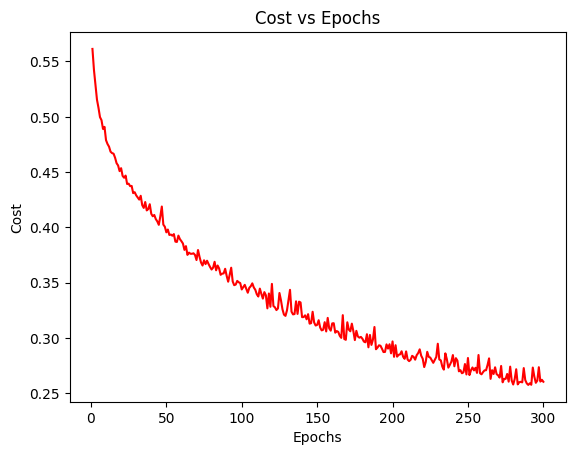

In [ ]:
J_history_batches, J_history_entire = model.train(x_train.T, y_train_bin, cost_func = 'soft',details=False,plot_costs=True)

In [ ]:
accuracy_train = model.get_accuracy(model.predict(x_train.T), y_train_bin)
print(f"The accuracy Training (seen data) of the model is {accuracy_train:.4f}")
accuracy_test = model.get_accuracy(model.predict(x_test.T), y_test_bin)
print(f"The accuracy Testing (unseen data) of the model is {accuracy_test:.4f}")

The accuracy Training (seen data) of the model is 89.1486
The accuracy Testing (unseen data) of the model is 76.0375


In [ ]:
print(y_train_bin.shape)

(72000,)


In [ ]:
layers2 = [1024,32,32,2]
act2 = ['relu','relu','soft']
model2 = NeuralNetwork(layers2, act2,alpha=1e-2,epochs=300)

Parameters initialized:  {'W1': (32, 1024), 'b1': (32, 1), 'W2': (32, 32), 'b2': (32, 1), 'W3': (2, 32), 'b3': (2, 1)}


Epoch: 001, Cost: 0.535456, accuracy: 72.6167
Epoch: 002, Cost: 0.506722, accuracy: 74.8903
Epoch: 003, Cost: 0.485068, accuracy: 76.3389
Epoch: 004, Cost: 0.467817, accuracy: 77.6958
Epoch: 005, Cost: 0.465102, accuracy: 77.6806
Epoch: 006, Cost: 0.448613, accuracy: 78.8333
Epoch: 007, Cost: 0.436215, accuracy: 79.5014
Epoch: 008, Cost: 0.430610, accuracy: 79.8583
Epoch: 009, Cost: 0.427803, accuracy: 80.1500
Epoch: 010, Cost: 0.406555, accuracy: 81.4139
Epoch: 011, Cost: 0.409697, accuracy: 81.1944
Epoch: 012, Cost: 0.395649, accuracy: 81.9917
Epoch: 013, Cost: 0.397517, accuracy: 81.8014
Epoch: 014, Cost: 0.380115, accuracy: 82.9222
Epoch: 015, Cost: 0.376784, accuracy: 83.1250
Epoch: 016, Cost: 0.368359, accuracy: 83.5708
Epoch: 017, Cost: 0.374909, accuracy: 83.1736
Epoch: 018, Cost: 0.361054, accuracy: 83.9653
Epoch: 019, Cost: 0.357704, accuracy: 84.3597
Epoch: 020, Cost: 0.356313, accuracy: 84.3944
Epoch: 021, Cost: 0.349689, accuracy: 84.5833
Epoch: 022, Cost: 0.342636, accura

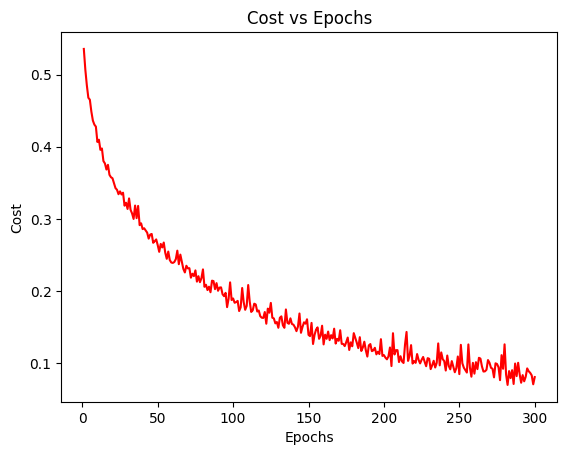

IndexError: list index out of range

In [ ]:
J_history_batches, J_history_entire = model2.train(x_train.T, y_train_bin, cost_func = 'soft',details=False,plot_costs=True)
accuracy_train2 = model2.get_accuracy(model2.predict(x_train.T), y_train_bin)
print(f"The accuracy Training (seen data) of the model is {accuracy_train2:.4f}")
accuracy_test2 = model2.get_accuracy(model2.predict(x_test.T), y_test_bin)
print(f"The accuracy Testing (unseen data) of the model is {accuracy_test2:.4f}")

In [ ]:
accuracy_train2 = model2.get_accuracy(model2.predict(x_train.T), y_train_bin)
print(f"The accuracy Training (seen data) of the model is {accuracy_train2:.4f}")
accuracy_test2 = model2.get_accuracy(model2.predict(x_test.T), y_test_bin)
print(f"The accuracy Testing (unseen data) of the model is {accuracy_test2:.4f}")

The accuracy Training (seen data) of the model is 97.0583
The accuracy Testing (unseen data) of the model is 75.2125


In [ ]:
layers3 = [1024,32,1]
act3 = ['relu','sigm']
model3= NeuralNetwork(layers3, act3,alpha=1e-2,epochs=300)

Parameters initialized:  {'W1': (32, 1024), 'b1': (32, 1), 'W2': (1, 32), 'b2': (1, 1)}


Epoch: 001, Cost: 0.534068, accuracy: 49.4722
Epoch: 002, Cost: 0.516619, accuracy: 48.5097
Epoch: 003, Cost: 0.494383, accuracy: 52.0139
Epoch: 004, Cost: 0.489939, accuracy: 47.8194
Epoch: 005, Cost: 0.471866, accuracy: 51.7514
Epoch: 006, Cost: 0.463239, accuracy: 53.7486
Epoch: 007, Cost: 0.452255, accuracy: 49.4764
Epoch: 008, Cost: 0.446100, accuracy: 52.0583
Epoch: 009, Cost: 0.442220, accuracy: 52.6528
Epoch: 010, Cost: 0.435172, accuracy: 53.5250
Epoch: 011, Cost: 0.423172, accuracy: 50.0250
Epoch: 012, Cost: 0.416942, accuracy: 48.5361
Epoch: 013, Cost: 0.413518, accuracy: 47.2528
Epoch: 014, Cost: 0.408116, accuracy: 49.8264
Epoch: 015, Cost: 0.404642, accuracy: 51.7681
Epoch: 016, Cost: 0.394931, accuracy: 49.7611
Epoch: 017, Cost: 0.397593, accuracy: 47.8056
Epoch: 018, Cost: 0.387441, accuracy: 49.2792
Epoch: 019, Cost: 0.400100, accuracy: 49.8069
Epoch: 020, Cost: 0.387306, accuracy: 48.2569
Epoch: 021, Cost: 0.391680, accuracy: 51.7806
Epoch: 022, Cost: 0.375028, accura

<ipython-input-51-b96c82b3825a>:32: RuntimeWarning: divide by zero encountered in log
  cost = (-1 / m) * np.sum(np.multiply(Y, np.log(A)) + np.multiply(1 - Y, np.log(1 - A)))
<ipython-input-51-b96c82b3825a>:32: RuntimeWarning: invalid value encountered in multiply
  cost = (-1 / m) * np.sum(np.multiply(Y, np.log(A)) + np.multiply(1 - Y, np.log(1 - A)))


Epoch: 128, Cost: nan, accuracy: 49.2417
Epoch: 129, Cost: 0.213381, accuracy: 50.5583
Epoch: 130, Cost: 0.193952, accuracy: 50.6653
Epoch: 131, Cost: 0.183847, accuracy: 50.4250
Epoch: 132, Cost: 0.183716, accuracy: 49.8028
Epoch: 133, Cost: nan, accuracy: 50.4875
Epoch: 134, Cost: nan, accuracy: 48.2889
Epoch: 135, Cost: 0.186846, accuracy: 50.0028
Epoch: 136, Cost: 0.180057, accuracy: 50.5611
Epoch: 137, Cost: 0.193359, accuracy: 49.3778
Epoch: 138, Cost: nan, accuracy: 49.6903
Epoch: 139, Cost: nan, accuracy: 51.1681
Epoch: 140, Cost: 0.193780, accuracy: 50.0181
Epoch: 141, Cost: nan, accuracy: 50.2111
Epoch: 142, Cost: nan, accuracy: 48.6292
Epoch: 143, Cost: nan, accuracy: 51.1667
Epoch: 144, Cost: nan, accuracy: 50.7069
Epoch: 145, Cost: 0.190113, accuracy: 51.6056
Epoch: 146, Cost: nan, accuracy: 49.7278
Epoch: 147, Cost: 0.177663, accuracy: 49.7069
Epoch: 148, Cost: nan, accuracy: 51.1889
Epoch: 149, Cost: nan, accuracy: 50.1806
Epoch: 150, Cost: nan, accuracy: 50.1542
Epoch: 

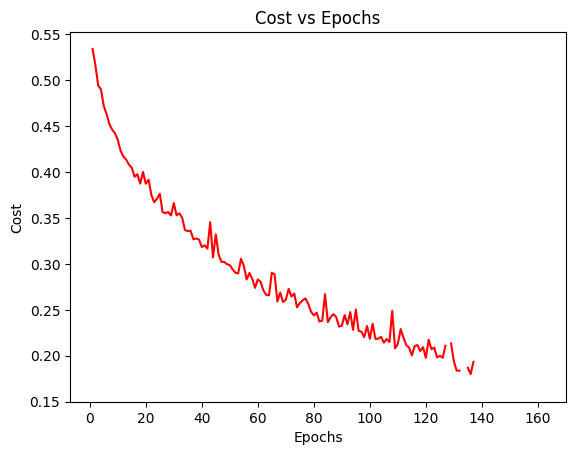

The accuracy Training (seen data) of the model is 96.0806
The accuracy Testing (unseen data) of the model is 76.6125


In [ ]:
J_history_batches3, J_history_entire3 = model3.train(x_train.T, y_train_bin, cost_func = 'sigm',details=False,plot_costs=True)
accuracy_train3 = model3.get_accuracy(model3.predict_bin(x_train.T), y_train_bin)
print(f"The accuracy Training (seen data) of the model is {accuracy_train3:.4f}")
accuracy_test3 = model3.get_accuracy(model3.predict_bin(x_test.T), y_test_bin)
print(f"The accuracy Testing (unseen data) of the model is {accuracy_test3:.4f}")

Parameters initialized:  {'W1': (32, 1024), 'b1': (32, 1), 'W2': (1, 32), 'b2': (1, 1)}
Working on fold 1.....
Epoch: 001, Cost: 0.577293, accuracy: 56.8281
Epoch: 002, Cost: 0.552294, accuracy: 52.8941
Epoch: 003, Cost: 0.537054, accuracy: 52.6076
Epoch: 004, Cost: 0.526805, accuracy: 50.6458
Epoch: 005, Cost: 0.517891, accuracy: 49.7378
Epoch: 006, Cost: 0.510288, accuracy: 51.6962
Epoch: 007, Cost: 0.504457, accuracy: 51.6372
Epoch: 008, Cost: 0.499140, accuracy: 49.2222
Epoch: 009, Cost: 0.492910, accuracy: 51.5295
Epoch: 010, Cost: 0.486692, accuracy: 49.8194
Epoch: 011, Cost: 0.482814, accuracy: 51.6615
Epoch: 012, Cost: 0.482473, accuracy: 49.9115
Epoch: 013, Cost: 0.473512, accuracy: 51.5972
Epoch: 014, Cost: 0.469333, accuracy: 51.0573
Epoch: 015, Cost: 0.465176, accuracy: 50.1337
Epoch: 016, Cost: 0.459894, accuracy: 50.8698
Epoch: 017, Cost: 0.460423, accuracy: 51.2674
Epoch: 018, Cost: 0.455810, accuracy: 49.7031
Epoch: 019, Cost: 0.450599, accuracy: 52.2639
Epoch: 020, Cos

<ipython-input-55-0325b4f4cd2d>:32: RuntimeWarning: divide by zero encountered in log
  cost = (-1 / m) * np.sum(np.multiply(Y, np.log(A)) + np.multiply(1 - Y, np.log(1 - A)))
<ipython-input-55-0325b4f4cd2d>:32: RuntimeWarning: invalid value encountered in multiply
  cost = (-1 / m) * np.sum(np.multiply(Y, np.log(A)) + np.multiply(1 - Y, np.log(1 - A)))


Epoch: 244, Cost: nan, accuracy: 49.3212
Epoch: 245, Cost: 0.141898, accuracy: 50.9653
Epoch: 246, Cost: nan, accuracy: 49.7135
Epoch: 247, Cost: 0.145335, accuracy: 50.5712
Epoch: 248, Cost: 0.140752, accuracy: 50.3993
Epoch: 249, Cost: 0.136387, accuracy: 49.7726
Epoch: 250, Cost: 0.151856, accuracy: 50.7743
Epoch: 251, Cost: 0.137115, accuracy: 50.6997
Epoch: 252, Cost: 0.131073, accuracy: 50.3628
Epoch: 253, Cost: 0.147990, accuracy: 50.1493
Epoch: 254, Cost: 0.137641, accuracy: 49.1128
Epoch: 255, Cost: 0.154537, accuracy: 50.7257
Epoch: 256, Cost: 0.137192, accuracy: 49.5122
Epoch: 257, Cost: 0.135979, accuracy: 49.1858
Epoch: 258, Cost: 0.148888, accuracy: 49.8872
Epoch: 259, Cost: nan, accuracy: 49.6424
Epoch: 260, Cost: nan, accuracy: 49.4167
Epoch: 261, Cost: 0.127798, accuracy: 50.2049
Epoch: 262, Cost: 0.135479, accuracy: 48.4774
Epoch: 263, Cost: 0.135393, accuracy: 49.4410
Epoch: 264, Cost: nan, accuracy: 49.7500
Epoch: 265, Cost: 0.130619, accuracy: 50.2986
Epoch: 266, C

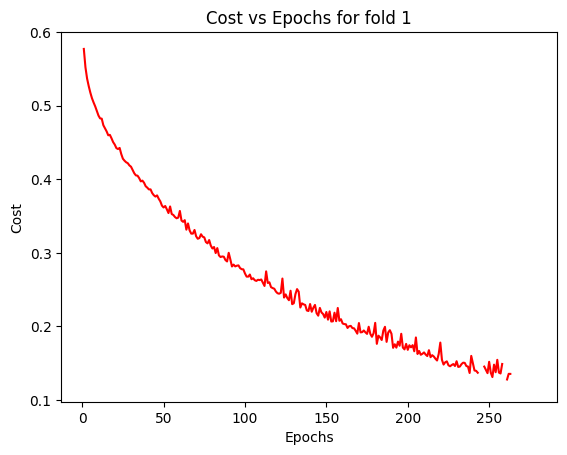

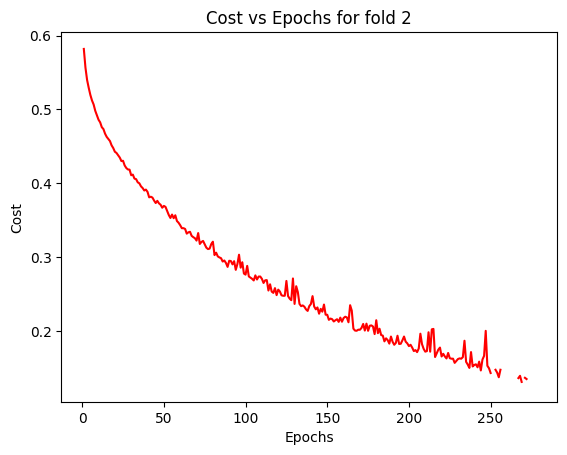

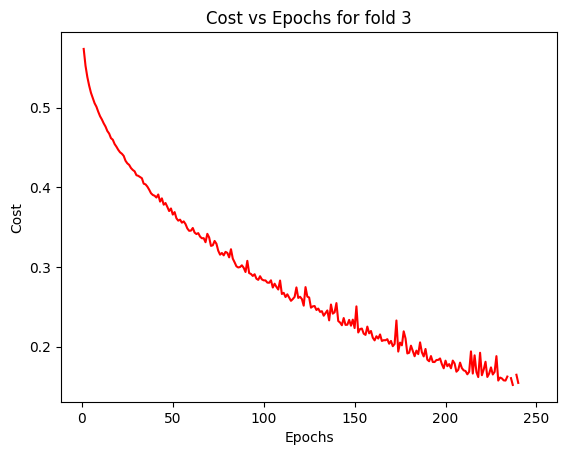

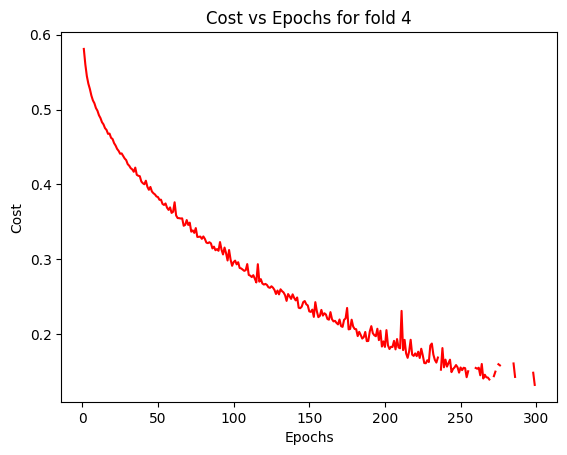

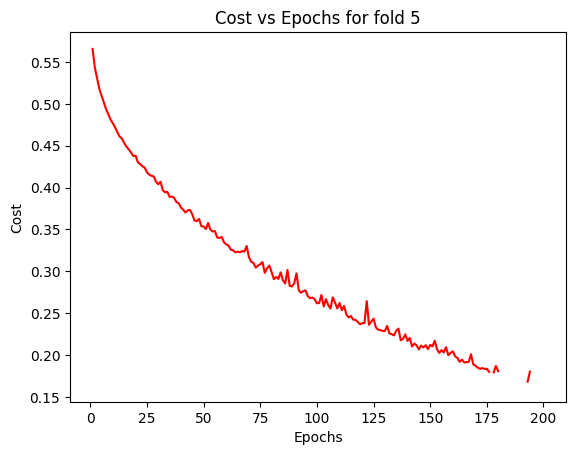

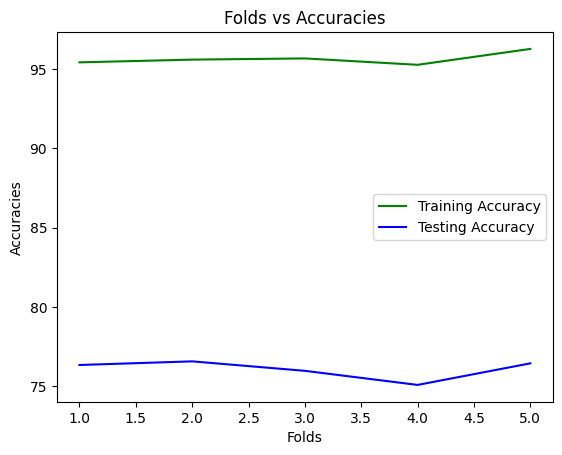

In [ ]:
layers4 = [1024,32,1]
act4 = ['relu','sigm']
model4= NeuralNetwork(layers4, act4,alpha=3e-3,epochs=300)
training_accuracies4, testing_accuracies4, mean_of_training_accuracies4, mean_of_testing_accuracies4 = model4.k_fold_cv(x_train.T, y_train_bin, 5, 'sigm', details=False,plot_acc=True,plot_cost_vs_epoch=True,retrain=False)

In [ ]:
# accuracy_train4 = model4.get_accuracy(model4.predict_bin(x_train.T), y_train_bin)
# print(f"The accuracy Training (seen data) of the model is {accuracy_train4:.4f}")
# accuracy_test4 = model4.get_accuracy(model4.predict_bin(x_test.T), y_test_bin)
# print(f"The accuracy Testing (unseen data) of the model is {accuracy_test4:.4f}")

Parameters initialized:  {'W1': (32, 1024), 'b1': (32, 1), 'W2': (2, 32), 'b2': (2, 1)}
Working on fold 1.....
Epoch: 001, Cost: 0.556196, accuracy: 70.8109
Epoch: 002, Cost: 0.535559, accuracy: 72.6031
Epoch: 003, Cost: 0.519488, accuracy: 73.8156
Epoch: 004, Cost: 0.509781, accuracy: 74.5234
Epoch: 005, Cost: 0.502279, accuracy: 75.0719
Epoch: 006, Cost: 0.494572, accuracy: 75.7078
Epoch: 007, Cost: 0.488408, accuracy: 76.1797
Epoch: 008, Cost: 0.484747, accuracy: 76.5250
Epoch: 009, Cost: 0.474528, accuracy: 77.1703
Epoch: 010, Cost: 0.475888, accuracy: 77.1328
Epoch: 011, Cost: 0.465191, accuracy: 77.7422
Epoch: 012, Cost: 0.461964, accuracy: 77.9734
Epoch: 013, Cost: 0.456747, accuracy: 78.3250
Epoch: 014, Cost: 0.452137, accuracy: 78.7906
Epoch: 015, Cost: 0.449004, accuracy: 78.8359
Epoch: 016, Cost: 0.447767, accuracy: 78.7188
Epoch: 017, Cost: 0.441198, accuracy: 79.3609
Epoch: 018, Cost: 0.435887, accuracy: 79.5781
Epoch: 019, Cost: 0.432877, accuracy: 79.8578
Epoch: 020, Cos

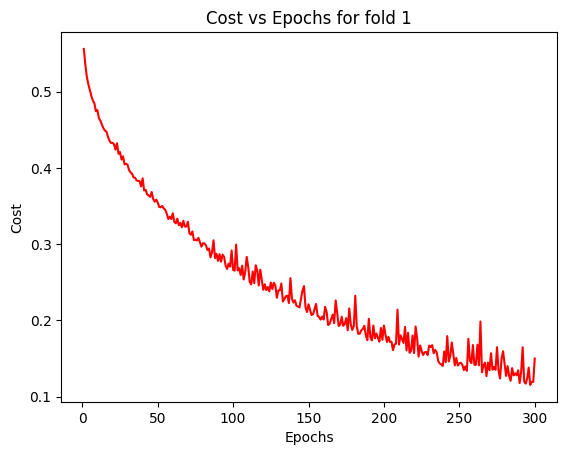

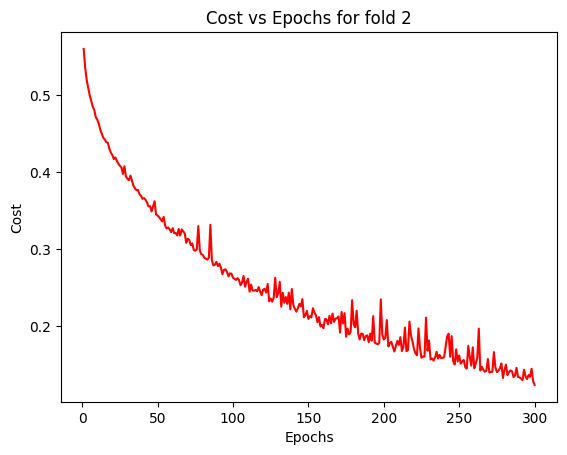

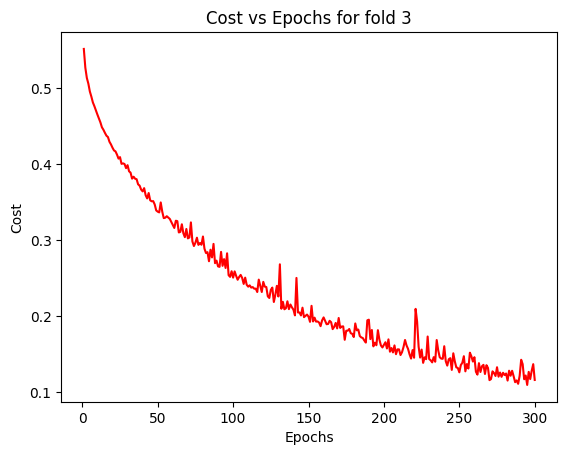

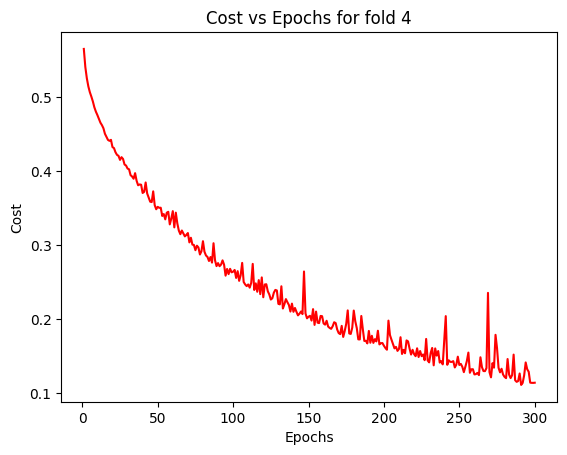

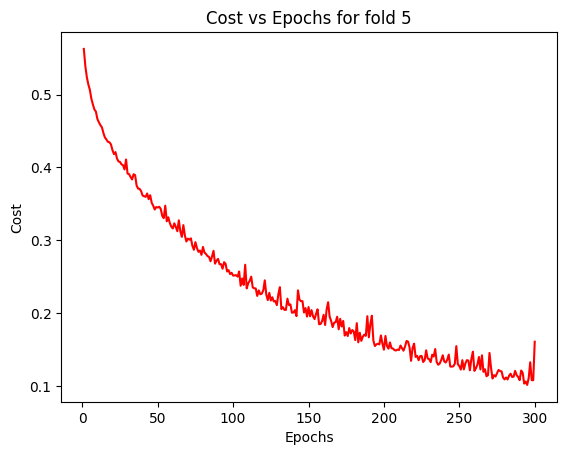

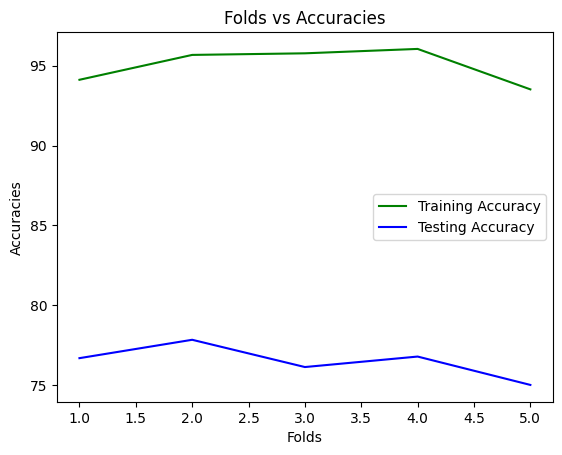

Epoch: 001, Cost: 0.294092, accuracy: 90.7625
Epoch: 002, Cost: 0.328100, accuracy: 88.8611
Epoch: 003, Cost: 0.277012, accuracy: 90.6000
Epoch: 004, Cost: 0.245034, accuracy: 91.5375
Epoch: 005, Cost: 0.245118, accuracy: 91.3208
Epoch: 006, Cost: 0.242884, accuracy: 91.2931
Epoch: 007, Cost: 0.236175, accuracy: 91.3986
Epoch: 008, Cost: 0.242361, accuracy: 90.9833
Epoch: 009, Cost: 0.212968, accuracy: 92.2736
Epoch: 010, Cost: 0.210876, accuracy: 92.2181
Epoch: 011, Cost: 0.231402, accuracy: 91.2542
Epoch: 012, Cost: 0.212350, accuracy: 91.9694
Epoch: 013, Cost: 0.206159, accuracy: 92.2611
Epoch: 014, Cost: 0.194674, accuracy: 92.8431
Epoch: 015, Cost: 0.186073, accuracy: 93.1500
Epoch: 016, Cost: 0.189836, accuracy: 92.8153
Epoch: 017, Cost: 0.191518, accuracy: 92.7250
Epoch: 018, Cost: 0.218173, accuracy: 91.4403
Epoch: 019, Cost: 0.201504, accuracy: 92.0889
Epoch: 020, Cost: 0.186940, accuracy: 92.8833
Epoch: 021, Cost: 0.191132, accuracy: 92.6472
Epoch: 022, Cost: 0.178724, accura

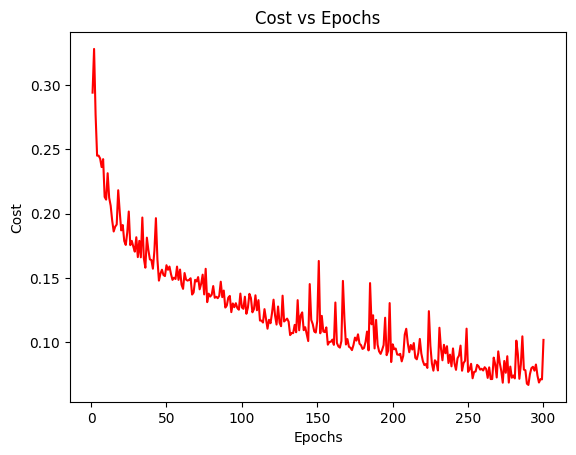

The accuracy Training (seen data) of the model is 50.0000
The accuracy Testing (unseen data) of the model is 50.0000


In [ ]:
layers5 = [1024,32,2]
act5 = ['relu','soft']
model5 = NeuralNetwork(layers5, act5,alpha=3e-3,epochs=300)
training_accuracies5, testing_accuracies5, mean_of_training_accuracies5, mean_of_testing_accuracies5= model5.k_fold_cv(X.T, Y_bin, 5, 'soft', details=False,plot_acc=True,plot_cost_vs_epoch=True,retrain=False)
# After k fold CV, training it again on x_train and then using x_test to get accuracies
model5.train(x_train.T, y_train_bin, cost_func = 'soft',details=False,plot_costs=True)
accuracy_train5 = model5.get_accuracy(model5.predict(x_train.T), y_train_bin)
print(f"The accuracy Training (seen data) of the model is {accuracy_train5:.4f}")
accuracy_test5 = model5.get_accuracy(model5.predict(x_test.T), y_test_bin)
print(f"The accuracy Testing (unseen data) of the model is {accuracy_test5:.4f}")

In [ ]:
accuracy_train5 = model5.get_accuracy(model5.predict(x_train.T), y_train_bin)
print(f"The accuracy Training (seen data) of the model is {accuracy_train5:.4f}")
accuracy_test5 = model5.get_accuracy(model5.predict(x_test.T), y_test_bin)
print(f"The accuracy Testing (unseen data) of the model is {accuracy_test5:.4f}")

The accuracy Training (seen data) of the model is 96.1736
The accuracy Testing (unseen data) of the model is 81.3250


Parameters initialized:  {'W1': (32, 1024), 'b1': (32, 1), 'W2': (32, 32), 'b2': (32, 1), 'W3': (10, 32), 'b3': (10, 1)}
Working on fold 1.....
Epoch: 001, Cost: 1.878104, accuracy: 35.7969
Epoch: 002, Cost: 1.766255, accuracy: 39.5047
Epoch: 003, Cost: 1.700403, accuracy: 41.5203
Epoch: 004, Cost: 1.654600, accuracy: 42.9344
Epoch: 005, Cost: 1.619949, accuracy: 43.9922
Epoch: 006, Cost: 1.594175, accuracy: 44.8719
Epoch: 007, Cost: 1.574935, accuracy: 45.5125
Epoch: 008, Cost: 1.555016, accuracy: 46.1562
Epoch: 009, Cost: 1.538090, accuracy: 46.7969
Epoch: 010, Cost: 1.524196, accuracy: 47.1187
Epoch: 011, Cost: 1.511698, accuracy: 47.6375
Epoch: 012, Cost: 1.502497, accuracy: 47.9625
Epoch: 013, Cost: 1.489800, accuracy: 48.2031
Epoch: 014, Cost: 1.479394, accuracy: 48.8141
Epoch: 015, Cost: 1.474115, accuracy: 48.7312
Epoch: 016, Cost: 1.465515, accuracy: 49.3234
Epoch: 017, Cost: 1.457460, accuracy: 49.3531
Epoch: 018, Cost: 1.450105, accuracy: 49.6375
Epoch: 019, Cost: 1.442061, 

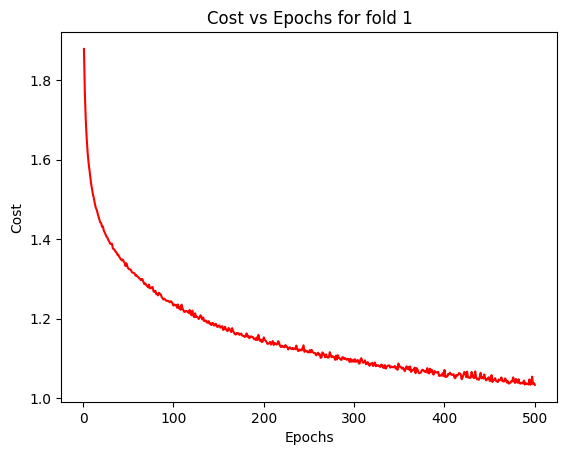

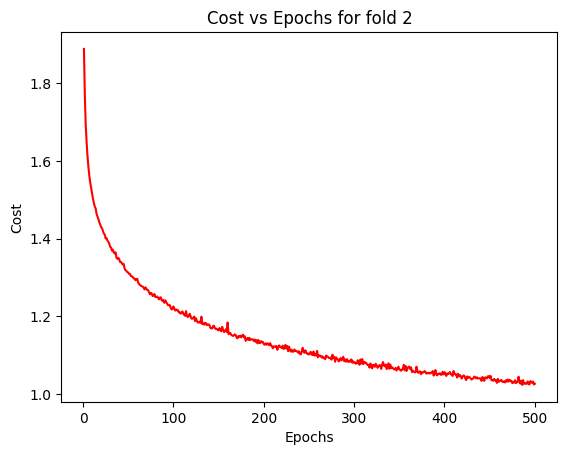

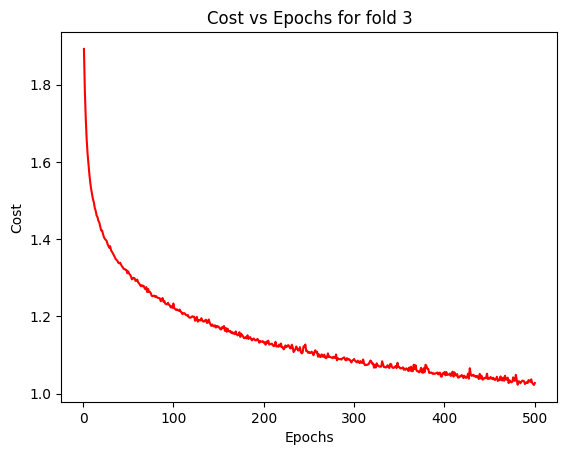

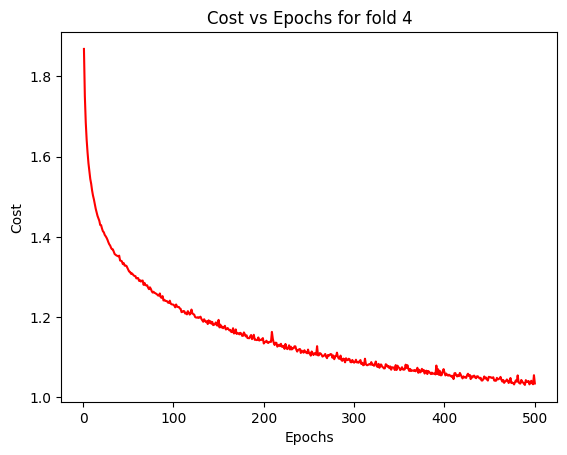

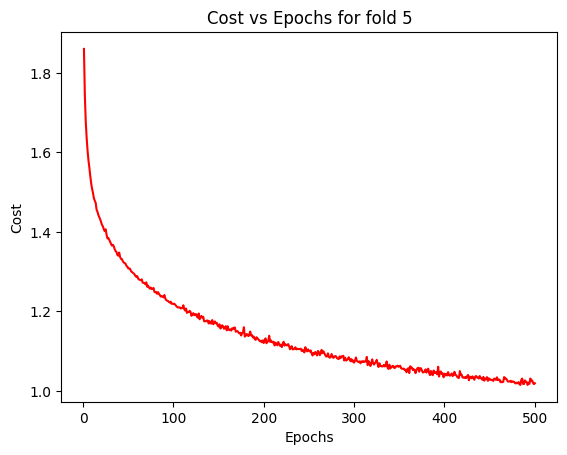

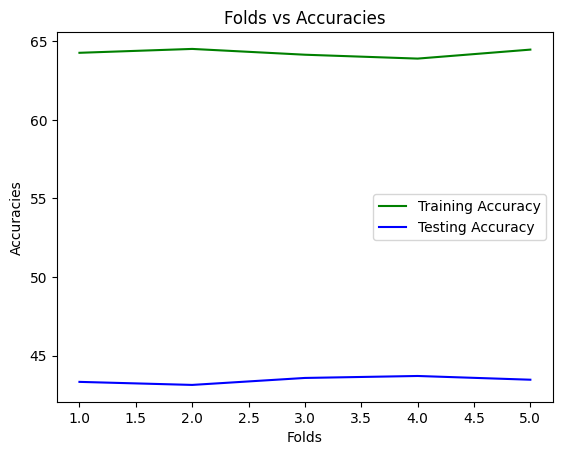

In [ ]:
layers6 = [1024,32,32,10]
act6 = ['relu','relu','soft']
model6 = NeuralNetwork(layers6, act6,alpha=3e-3,epochs=500)
training_accuracies6, testing_accuracies6, mean_of_training_accuracies6, mean_of_testing_accuracies6= model6.k_fold_cv(X.T, Y_class, 5, 'soft', details=False,plot_acc=True,plot_cost_vs_epoch=True,retrain=False)

Epoch: 001, Cost: 1.195041, accuracy: 59.5278
Epoch: 002, Cost: 1.170437, accuracy: 60.2694
Epoch: 003, Cost: 1.169241, accuracy: 60.3083
Epoch: 004, Cost: 1.158787, accuracy: 60.5986
Epoch: 005, Cost: 1.163418, accuracy: 60.2903
Epoch: 006, Cost: 1.152469, accuracy: 60.5667
Epoch: 007, Cost: 1.148464, accuracy: 60.7708
Epoch: 008, Cost: 1.145479, accuracy: 60.6972
Epoch: 009, Cost: 1.145263, accuracy: 60.6653
Epoch: 010, Cost: 1.143760, accuracy: 60.7472
Epoch: 011, Cost: 1.151149, accuracy: 60.4667
Epoch: 012, Cost: 1.140694, accuracy: 60.9514
Epoch: 013, Cost: 1.143537, accuracy: 60.7764
Epoch: 014, Cost: 1.137518, accuracy: 60.8403
Epoch: 015, Cost: 1.137722, accuracy: 60.9528
Epoch: 016, Cost: 1.134994, accuracy: 60.9917
Epoch: 017, Cost: 1.133750, accuracy: 60.8917
Epoch: 018, Cost: 1.132596, accuracy: 61.1736
Epoch: 019, Cost: 1.129145, accuracy: 61.1000
Epoch: 020, Cost: 1.129511, accuracy: 60.9583
Epoch: 021, Cost: 1.144491, accuracy: 60.4903
Epoch: 022, Cost: 1.129116, accura

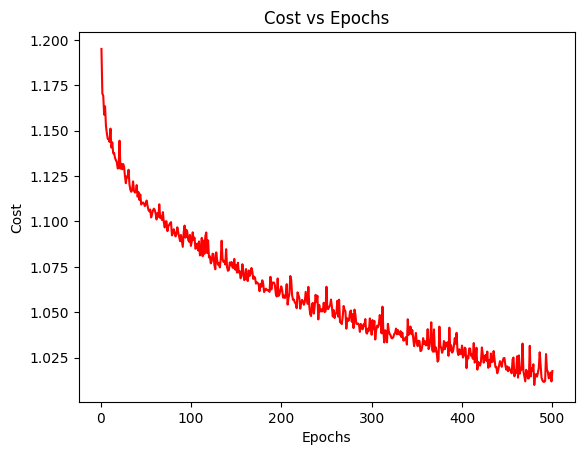

The accuracy Training (seen data) of the model is 64.5000
The accuracy Testing (unseen data) of the model is 48.2125


In [ ]:
model6.train(x_train.T, y_train_class, cost_func = 'soft',details=False,plot_costs=True)
accuracy_train6 = model6.get_accuracy(model6.predict(x_train.T), y_train_class)
print(f"The accuracy Training (seen data) of the model is {accuracy_train6:.4f}")
accuracy_test6 = model6.get_accuracy(model6.predict(x_test.T), y_test_class)
print(f"The accuracy Testing (unseen data) of the model is {accuracy_test6:.4f}")

Parameters initialized:  {'W1': (64, 1024), 'b1': (64, 1), 'W2': (64, 64), 'b2': (64, 1), 'W3': (10, 64), 'b3': (10, 1)}
Working on fold 1.....
Epoch: 001, Cost: 1.644238, accuracy: 42.4188
Epoch: 002, Cost: 1.549569, accuracy: 46.0891
Epoch: 003, Cost: 1.528249, accuracy: 46.4766
Epoch: 004, Cost: 1.511959, accuracy: 47.0453
Epoch: 005, Cost: 1.458617, accuracy: 48.3219
Epoch: 006, Cost: 1.481878, accuracy: 49.0781
Epoch: 007, Cost: 1.423830, accuracy: 50.0781
Epoch: 008, Cost: 1.331418, accuracy: 53.4078
Epoch: 009, Cost: 1.356094, accuracy: 52.2906
Epoch: 010, Cost: 1.320046, accuracy: 53.6750
Epoch: 011, Cost: 1.309768, accuracy: 53.7687
Epoch: 012, Cost: 1.279067, accuracy: 55.0000
Epoch: 013, Cost: 1.303196, accuracy: 54.1125
Epoch: 014, Cost: 1.293925, accuracy: 54.2828
Epoch: 015, Cost: 1.258684, accuracy: 56.2484
Epoch: 016, Cost: 1.255470, accuracy: 55.3766
Epoch: 017, Cost: 1.277982, accuracy: 54.7516
Epoch: 018, Cost: 1.226259, accuracy: 57.0141
Epoch: 019, Cost: 1.243289, 

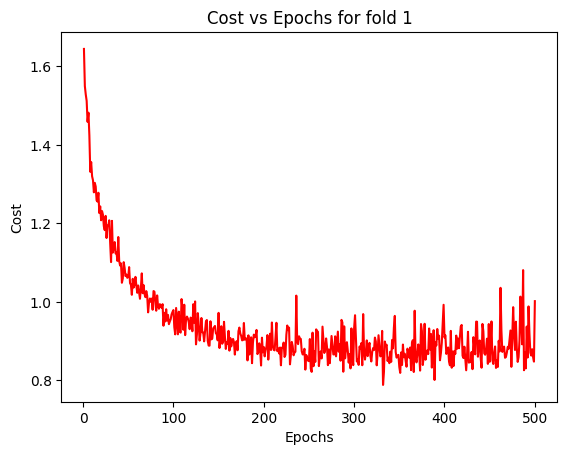

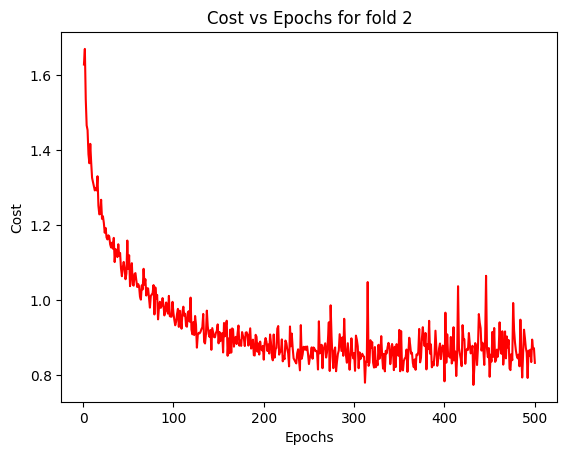

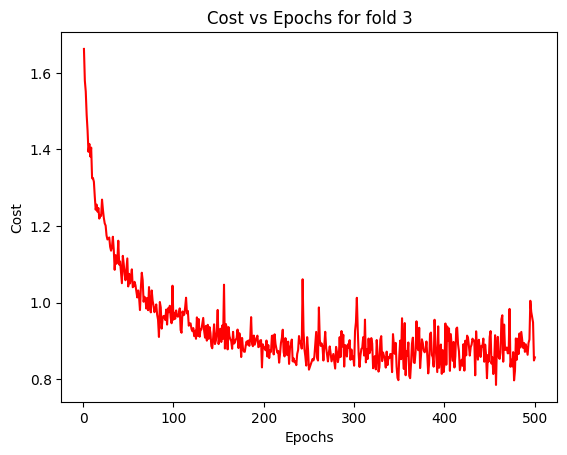

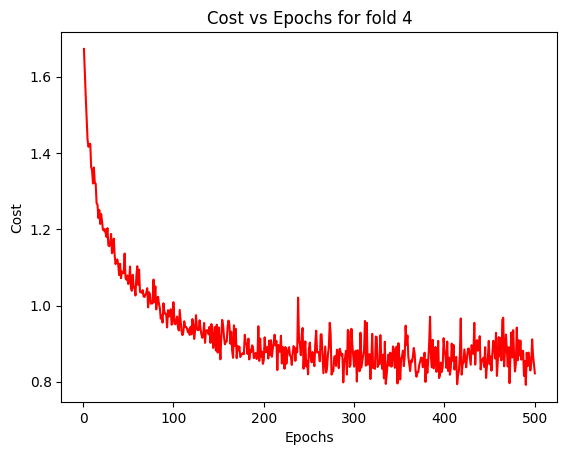

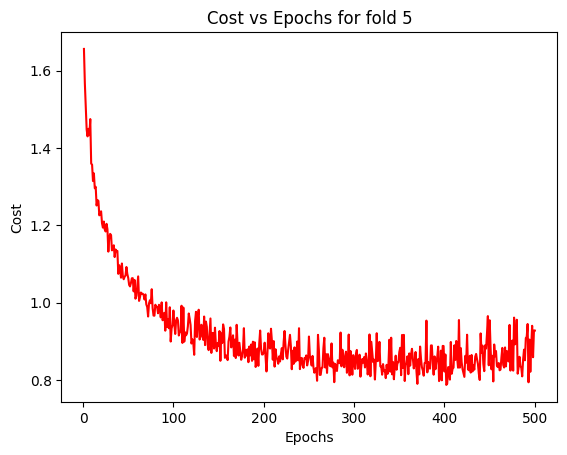

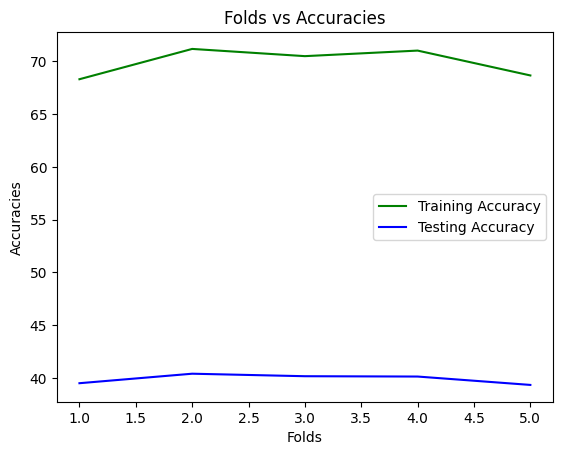

In [ ]:
layers7 = [1024,64,64,10]
act_funcs7 = ['relu','relu', 'soft']
model7 = NeuralNetwork(layers7, act_funcs7,alpha=1e-1,epochs=500)
training_accuracies7, testing_accuracies7, mean_of_training_accuracies7, mean_of_testing_accuracies7 = model7.k_fold_cv(X.T, Y_class, 5, 'soft', details=False,plot_acc=True,plot_cost_vs_epoch=True,retrain=False)

Retraining on x_train: ...
Epoch: 001, Cost: 1.312733, accuracy: 57.9125
Epoch: 002, Cost: 1.282921, accuracy: 58.6514
Epoch: 003, Cost: 1.154524, accuracy: 62.1097
Epoch: 004, Cost: 1.182699, accuracy: 62.3389
Epoch: 005, Cost: 1.116744, accuracy: 63.3931
Epoch: 006, Cost: 1.125767, accuracy: 63.2569
Epoch: 007, Cost: 1.121122, accuracy: 62.8583
Epoch: 008, Cost: 1.097346, accuracy: 63.4778
Epoch: 009, Cost: 1.120121, accuracy: 62.9375
Epoch: 010, Cost: 1.049321, accuracy: 64.7542
Epoch: 011, Cost: 1.036131, accuracy: 65.3167
Epoch: 012, Cost: 1.093062, accuracy: 63.1569
Epoch: 013, Cost: 1.079746, accuracy: 64.2208
Epoch: 014, Cost: 1.090373, accuracy: 63.1222
Epoch: 015, Cost: 1.045228, accuracy: 65.3444
Epoch: 016, Cost: 1.041223, accuracy: 65.1931
Epoch: 017, Cost: 1.096621, accuracy: 64.3569
Epoch: 018, Cost: 1.086094, accuracy: 63.6667
Epoch: 019, Cost: 1.043168, accuracy: 65.2069
Epoch: 020, Cost: 1.024335, accuracy: 65.5306
Epoch: 021, Cost: 1.018118, accuracy: 66.0847
Epoch: 

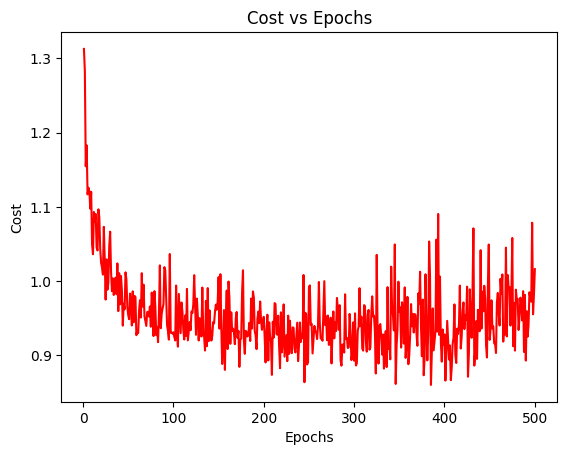

Retraining complete.
Classification Report for Training: 
                    precision    recall  f1-score  support
0                    0.557326  0.775468  0.648545   7215.0
1                    0.830520  0.821280  0.825874   7190.0
2                    0.638565  0.702903  0.669191   7166.0
3                    0.367336  0.775177  0.498463   7219.0
4                    0.880683  0.509250  0.645338   7189.0
5                    0.701860  0.565344  0.626249   7208.0
6                    0.913676  0.697015  0.790774   7304.0
7                    0.854264  0.725562  0.784671   7069.0
8                    0.945733  0.529997  0.679305   7234.0
9                    0.822686  0.700527  0.756708   7206.0
Average (weighted)   0.751285  0.680153  0.692417  72000.0
Accuracy: 68.01527777777778%
Classification Report for Testing: 
                    precision    recall  f1-score  support
0                    0.440999  0.626683  0.517695    817.0
1                    0.601562  0.573913  0.587413  

In [ ]:
print("Retraining on x_train: ...")
model7.train(x_train.T, y_train_class, cost_func = 'soft',details=False,plot_costs=True)
print("This")
print("Retraining complete.")
print("Classification Report for Training: ")
model7.classification_report(y_train_class, model7.predict(x_train.T))
print("Classification Report for Testing: ")
model7.classification_report(y_test_class, model7.predict(x_test.T))

In [25]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore


class NeuralNetwork:
  def __init__(self, layer_list, act_funcs, alpha = 3e-2, batch_size=32, epochs=100, reg_param=None):
    self.layer_list = layer_list
    self.alpha = alpha
    self.batch_size = batch_size
    self.epochs = epochs
    self.params = {}
    self.cache = {}
    self.reg_param = reg_param
    self.grads = {}
    self.act_funcs = act_funcs
    self._init_params(log_it=True)

  #Useful funcs:
  def _relu(self, z):
    return np.maximum(z,0)
  def _softmax(self, z):
    A = np.exp(z)/sum(np.exp(z))
    return A
  def _sigmoid(self, z):
    return 1/(1+np.exp(-z))
  def _reluDer(self, z):
    return (z >0).astype(int)
  def _get_deltaZ_lastLayer(self,A, Y):
    return A - Y
  def _compute_cost(self,A, Y, cost_func,reg=True):
    if 'soft' in cost_func:
        m = Y.shape[1]
        cost = -np.sum(Y * np.log(A)) / m
        cost += self._add_reg_term(m) if reg else 0
        return cost
    elif 'sigm' in cost_func:
        m = Y.shape[1]
        cost = (-1 / m) * np.sum(np.multiply(Y, np.log(A)) + np.multiply(1 - Y, np.log(1 - A)))
        cost += self._add_reg_term(m) if reg else 0
        return cost
    else:
        raise Exception("Unsupported Cost function")

  def _add_reg_term(self,m):
    L = len(self.layer_list) - 1
    reg_cost = 0.0
    for l in range(1,L+1):
      reg_cost += np.sum(self.params[f"W{l}"]**2)
    reg_cost = (reg_cost*self.reg_param)/(2*m)
    return reg_cost
  def _one_hot(self, Y):
    uniq_labels = np.unique(Y)
    C = len(uniq_labels)
    m = Y.size
    one_hot_Y = np.zeros((C, m))
    label_to_index = {label: index for index, label in enumerate(uniq_labels)}
    indices = [label_to_index[label] for label in Y]
    one_hot_Y[indices, np.arange(m)] = 1
    # for i in range(m):
    #   one_hot_Y[Y[i], i] = 1
    return one_hot_Y

    #params create:
  def _init_params(self,log_it=True):
    L = len(self.layer_list)
    for l in range(1,L):
      self.params[f"W{l}"] = np.random.randn(self.layer_list[l], self.layer_list[l-1]) * np.sqrt(2 / self.layer_list[l-1]) #He method
      self.params[f"b{l}"] = np.random.randn(self.layer_list[l], 1) * np.sqrt(2 / self.layer_list[l-1])
    print("Parameters initialized: ", {key: val.shape for key, val in self.params.items()}) if log_it else None
  def _fwd_prp(self, X):
    self.cache["A0"] = X
    L = len(self.layer_list) - 1
    for l in range(1, L+1):
      Z = np.dot(self.params[f"W{l}"], self.cache[f"A{l-1}"]) + self.params[f"b{l}"]
      self.cache[f"Z{l}"] = Z
      if "relu" in self.act_funcs[l-1]:
        self.cache[f"A{l}"] = self._relu(Z)
      elif 'sig' in self.act_funcs[l-1]:
        self.cache[f"A{l}"] = self._sigmoid(Z)
      elif 'soft' in self.act_funcs[l-1]:
        self.cache[f"A{l}"] = self._softmax(Z)
      else:
        raise Exception("Unsupported activation function")
    return self.cache[f"A{L}"]
  def _update_grads(self, X, Y):
    #No of layers
    L = len(self.layer_list) - 1
    m = Y.shape[1]
    A_last = self.cache[f"A{L}"]
    if self.act_funcs[L-1] == 'sigmoid' or "softmax":
      dZ = self._get_deltaZ_lastLayer(A_last, Y)
    self.grads[f"dZ{L}"] = dZ
    self.grads[f"dW{L}"] = np.dot(dZ, self.cache[f"A{L-1}"].T) / m
    self.grads[f"db{L}"] = np.sum(dZ, axis = 1, keepdims = True)
    if self.reg_param is not None:
      self.grads[f"dW{L}"] += (self.reg_param*self.params[f"W{L}"])/(2*m)
    for l in reversed(range(1,L)):
      dA = np.dot(self.params[f"W{l+1}"].T, dZ) #this is the dA of the current layer
      Z = self.cache[f"Z{l}"]
      A = self.cache[f"A{l}"]
      activation = self.act_funcs[l-1] #when l = 1, it is the first hidden layer, correspondingly , activations[0] gives the act func of that layer
      if activation == "relu":
        dZ = dA * self._reluDer(Z)
      elif activation == "sigmoid":
        dZ = dA * (A * (1 - A))
      else:
        raise ValueError(f"Unsupported activation function: {activation}")

      self.grads[f"dZ{l}"] = dZ
      self.grads[f"dW{l}"] = (1/m)*np.dot(dZ, self.cache[f"A{l-1}"].T)
      self.grads[f"db{l}"] = (1/m)*np.sum(dZ, axis = 1, keepdims = True)
      if self.reg_param is not None:
        self.grads[f"dW{l}"] += (self.reg_param*self.params[f"W{l}"])/(2*m)

    # return self.grads
  def _update_params(self):
      L = len(self.layer_list) - 1
      for l in range(1, L + 1):
          self.params[f"W{l}"] -= self.alpha*self.grads[f"dW{l}"]
          self.params[f"b{l}"] -= self.alpha*self.grads[f"db{l}"]


  def train(self, X, Y, cost_func = 'soft',details=True,plot_costs=True):
    m = X.shape[1]
    if 'sigm' in self.act_funcs[-1]:
      Y = Y.reshape(1,m)
    else:
      Y = self._one_hot(Y)
    J_history_batches = []
    J_history_entire = []
    for epoch in range(1, self.epochs+1):
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]

        batches = m // self.batch_size
        for k in range(0, batches):
            mini_batch_X = X_shuffled[:, k*self.batch_size:(k+1)*self.batch_size]
            mini_batch_Y = Y_shuffled[:, k*self.batch_size:(k+1)*self.batch_size]

            A_last = self._fwd_prp(mini_batch_X)
            self._update_grads(mini_batch_X, mini_batch_Y)
            self._update_params()
            cost = self._compute_cost(A_last, mini_batch_Y, cost_func,reg=False)
            J_history_batches.append(cost)
            cost += self._add_reg_term(mini_batch_Y.shape[1]) if self.reg_param is not None else 0.0
            # First I am appending normal cost, and then I am adding the reg term to it, for printing
            if details:
                print(f"Epoch: {epoch:03d}, Batch: {k+1}/{batches}, Cost: {cost:.6f}")
        if m % batches != 0:
            mini_batch_X = X_shuffled[:, batches*self.batch_size:m]
            mini_batch_Y = Y_shuffled[:, batches*self.batch_size:m]

            A_last = self._fwd_prp(mini_batch_X)
            self._update_grads(mini_batch_X, mini_batch_Y)
            self._update_params()
            cost = self._compute_cost(A_last, mini_batch_Y, cost_func)
            J_history_batches.append(cost)
            cost += self._add_reg_term(mini_batch_Y.shape[1]) if self.reg_param is not None else 0
            if details:
                print(f"Epoch: {epoch:03d}, Batch: last, Cost: {cost:.6f}")
        A_last = self._fwd_prp(X_shuffled)
        cost = self._compute_cost(A_last, Y_shuffled, cost_func,reg=False)
        J_history_entire.append(cost)
        cost += self._add_reg_term(Y_shuffled.shape[1]) if self.reg_param is not None else 0
        if 'sigm' in self.act_funcs[-1]:
          predictions = self.predict_bin(X_shuffled)
        else:
          predictions = self.predict(X_shuffled)
        true_Y = np.argmax(Y_shuffled, axis=0)
        accuracy = self.get_accuracy(predictions, true_Y)
        print(f"Epoch: {epoch:03d}, Cost: {cost:.6f}, accuracy: {accuracy:.4f}")
    self._plotter(J_history_entire) if plot_costs else None
    return J_history_batches, J_history_entire


  def predict(self, X):
      A_last = self._fwd_prp(X)
      predictions = np.argmax(A_last, axis = 0)
      return predictions
  def get_accuracy(self, predictions, Y):
      accuracy = 100* np.mean(predictions == Y)
      return accuracy

  def k_fold_cv(self, X, Y, k_folds, cost_func, details=True,plot_acc=True,plot_cost_vs_epoch=True,retrain=True):
    """Dont pass in standardized X in here"""
    m = X.shape[1]
    indices = np.random.permutation(m)
    X_shuffled = X[:, indices]
    if plot_cost_vs_epoch:
      J_hist_list = []
    # Y = self._one_hot(Y) dont use one hot here, as the train function takes the 1d Y and does the one hot there only
    Y_shuffled = Y[indices]
    fold_size = m//k_folds
    training_accuracies = []
    testing_accuracies = []
    for fold in range(k_folds):
      print(f"Working on fold {fold+1}.....")
      test_start = fold*fold_size
      test_end = (fold+1)*fold_size if fold < k_folds - 1 else m
      self._init_params(log_it=False)
      X_train = np.concatenate((X_shuffled[:, :test_start], X_shuffled[:, test_end:]), axis = 1)
      Y_train = np.concatenate((Y_shuffled[:test_start], Y_shuffled[test_end:]))
      X_test = X_shuffled[:,test_start:test_end]
      Y_test = Y_shuffled[test_start:test_end]
      X_train_mean = np.mean(X_train, axis=1)
      X_train_std = np.std(X_train, axis = 1)
      X_train = (X_train - X_train_mean)/X_train_std
      X_test  = (X_test - X_train_mean)/X_train_std
      useless,J_hist = self.train(X_train, Y_train, cost_func, details,plot_costs=False)
      if plot_cost_vs_epoch:
        J_hist_list.append(J_hist)
      training_predictions = self.predict_bin(X_train) if 'sigm' in self.act_funcs[-1] else self.predict(X_train)
      testing_predictions = self.predict_bin(X_test) if 'sigm' in self.act_funcs[-1] else self.predict(X_test)
      # training_predictions = self.predict(X_train)
      # testing_predictions = self.predict(X_test)
      training_accuracy = self.get_accuracy(training_predictions, Y_train)
      print(f"The training accuracy for fold: {fold+1} is {training_accuracy:.4f}")
      testing_accuracy = self.get_accuracy(testing_predictions, Y_test)
      print(f"The testing accuracy for fold: {fold+1} is {testing_accuracy:.4f}")
      training_accuracies.append(training_accuracy)
      testing_accuracies.append(testing_accuracy)
      print(f"Fold {fold+1} Completed!")
      print(f"Starting fold {fold+2}") if fold < k_folds - 1 else None
    mean_of_training_accuracies = np.mean(training_accuracies)
    mean_of_testing_accuracies = np.mean(testing_accuracies)
    print(f"Mean of training accuracies: {mean_of_training_accuracies:.4f}")
    print(f"Mean of testing accuracies: {mean_of_testing_accuracies:.4f}")
    if plot_cost_vs_epoch:
      for fold in range(k_folds):
            plt.plot(np.arange(1,len(J_hist_list[fold])+1), J_hist_list[fold], c='r')
            plt.xlabel('Epochs')
            plt.ylabel('Cost')
            plt.title(f"Cost vs Epochs for fold {fold+1}")
            plt.show()
    if retrain:
      print("Retraining the model on the entire dataset....")
      self._init_params(log_it=True)
      self.train(X, Y, cost_func, details,plot_costs=False)
      print("Retraining complete.")


    self._plotter_for_CV(training_accuracies,testing_accuracies) if plot_acc else None

    return training_accuracies, testing_accuracies, mean_of_training_accuracies, mean_of_testing_accuracies


  def _plotter(self, J_history):
    plt.plot(np.arange(1,len(J_history)+1), J_history, c='r')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title("Cost vs Epochs")
    plt.show()

  def _plotter_for_CV(self, training_accuracies, testing_accuracies):
    k_folds = len(training_accuracies)
    plt.plot(np.arange(1,k_folds+1), training_accuracies, c='green',label='Training Accuracy')
    plt.plot(np.arange(1,k_folds+1), testing_accuracies, c='blue',label='Testing Accuracy')
    plt.xlabel("Folds")
    plt.ylabel("Accuracies")
    plt.title("Folds vs Accuracies")
    plt.legend()
    plt.show()
  def predict_bin(self,X):
      A_last = self._fwd_prp(X)
      # predictions = np.zeros((X.shape[0],))
      # for i in range(len(X.shape[0])):
      #   predictions[i] = 1 if A_last[i] > 0.5 else 0
      predictions = (A_last > 0.5).astype(int)
      return predictions

  def get_conf_mat(self, Y_act, Y_pred):
    n_cls = len(np.unique(Y_act))
    con_mat = np.zeros((n_cls, n_cls))
    for indx, label in enumerate(Y_act):
      con_mat[label, Y_pred[indx]] += 1

    return con_mat

  def print_con_mat(self, con_mat):
    print("Confusion matrix with predictions on X axis and actual values on Y")
    classes= np.arange(con_mat.shape[0])
    table = pd.DataFrame(con_mat, index=classes, columns=classes)
    print(table)

  def get_precision(self,con_mat):
    precs = np.zeros((con_mat.shape[0],))
    for i in range(con_mat.shape[0]):
      precs[i] = con_mat[i,i]/np.sum(con_mat[:,i])

    return precs

  def get_recall(self, con_mat):
    recs = np.zeros((con_mat.shape[0],))
    for i in range(con_mat.shape[0]):
      recs[i] = con_mat[i,i]/np.sum(con_mat[i,:])

    return recs

  def get_f1s(self, con_mat):
    precs = self.get_precision(con_mat)
    recs = self.get_recall(con_mat)
    f1s = 2*recs*precs/(recs + precs)
    return f1s

  def classification_report(self, Y_act, Y_pred):
    con_mat = self.get_conf_mat(Y_act, Y_pred)
    precs = self.get_precision(con_mat)
    recs = self.get_recall(con_mat)
    f1s = self.get_f1s(con_mat)
    supports = con_mat.sum(axis=1)
    classes= np.arange(con_mat.shape[0])
    reports = []
    for i in range(con_mat.shape[0]):
      reports.append([precs[i], recs[i], f1s[i], supports[i]])
    table1 = pd.DataFrame(reports,index=classes, columns=['precision','recall','f1-score','support'])
    # print(table1)
    wted_prec = np.average(precs, weights=supports)
    wted_rec = np.average(recs, weights=supports)
    wted_f1 = np.average(f1s, weights=supports)
    tot_support = np.sum(supports)
    wted_data = [[wted_prec,wted_rec,wted_f1,tot_support]]
    table2 = pd.DataFrame(wted_data,index=['Average (weighted)'],columns=['precision', 'recall', 'f1-score', 'support'])
    # print('\n\n', table2)
    table = pd.concat([table1, table2])
    print(table)
    print(f"Accuracy: {self.get_accuracy(Y_pred, Y_act)}%")

Parameters initialized:  {'W1': (128, 1024), 'b1': (128, 1), 'W2': (128, 128), 'b2': (128, 1), 'W3': (10, 128), 'b3': (10, 1)}
Working on fold 1.....
Epoch: 001, Cost: 1.760495, accuracy: 39.1922
Epoch: 002, Cost: 1.632130, accuracy: 43.6031
Epoch: 003, Cost: 1.555491, accuracy: 46.2547
Epoch: 004, Cost: 1.501839, accuracy: 48.1797
Epoch: 005, Cost: 1.459043, accuracy: 49.6078
Epoch: 006, Cost: 1.427791, accuracy: 50.7969
Epoch: 007, Cost: 1.396066, accuracy: 51.8125
Epoch: 008, Cost: 1.370694, accuracy: 52.6656
Epoch: 009, Cost: 1.346849, accuracy: 53.5594
Epoch: 010, Cost: 1.327140, accuracy: 54.1422
Epoch: 011, Cost: 1.308233, accuracy: 54.8625
Epoch: 012, Cost: 1.292171, accuracy: 55.4625
Epoch: 013, Cost: 1.269428, accuracy: 56.1875
Epoch: 014, Cost: 1.255876, accuracy: 56.7109
Epoch: 015, Cost: 1.240682, accuracy: 57.3891
Epoch: 016, Cost: 1.237521, accuracy: 57.2594
Epoch: 017, Cost: 1.217433, accuracy: 58.0656
Epoch: 018, Cost: 1.202491, accuracy: 58.7125
Epoch: 019, Cost: 1.17

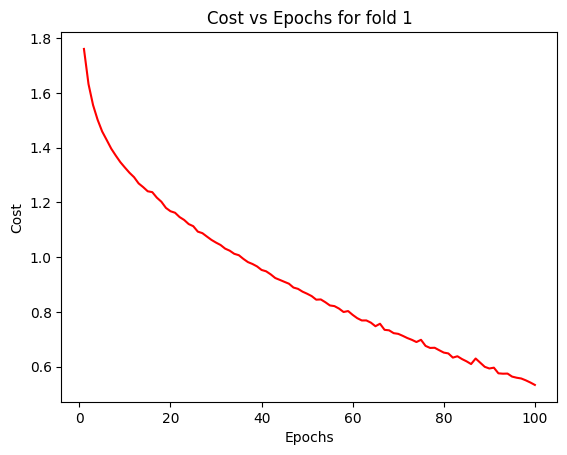

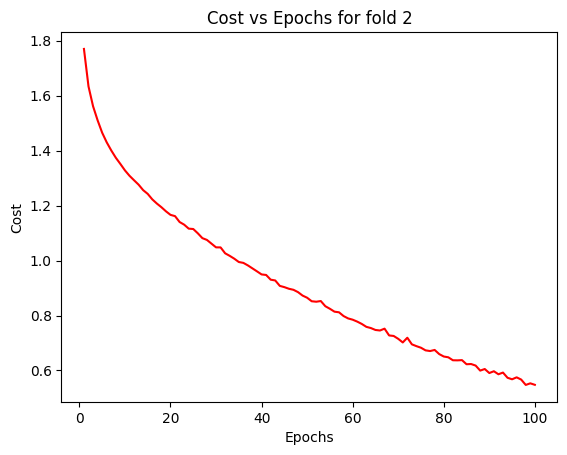

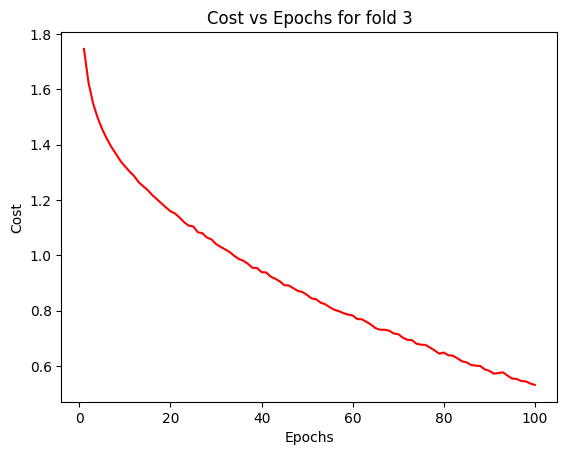

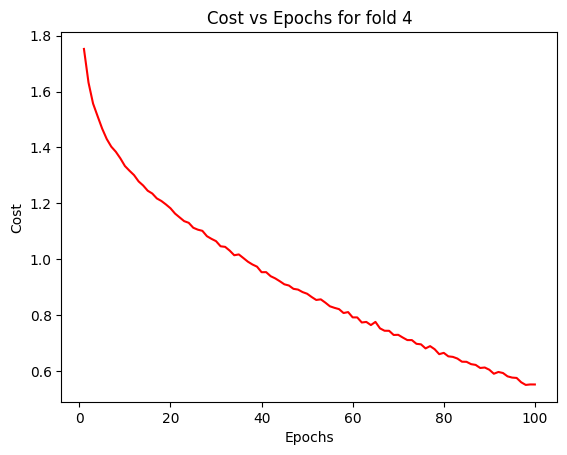

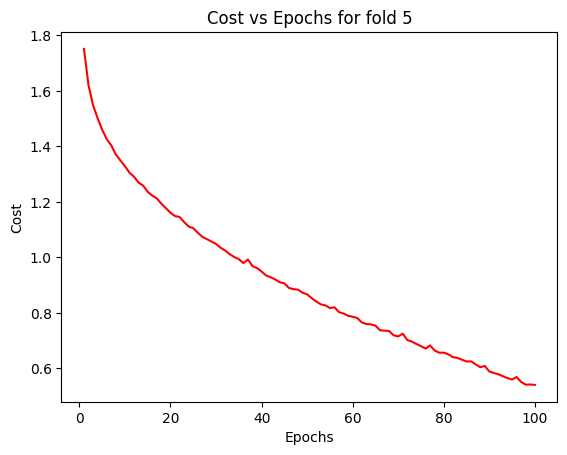

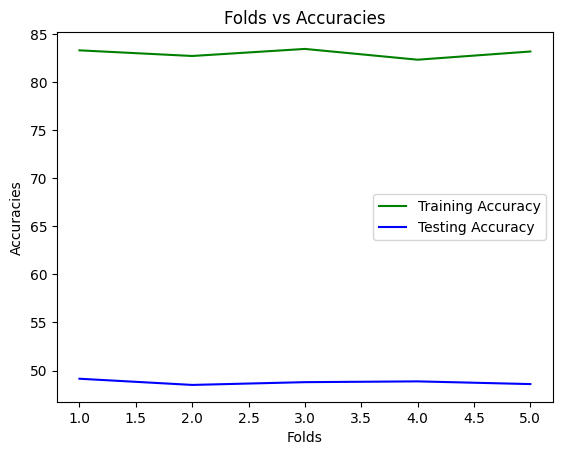

([83.303125, 82.7171875, 83.4515625, 82.3296875, 83.1828125],
 [49.143750000000004, 48.5, 48.7875, 48.86875, 48.5875],
 82.996875,
 48.7775)

In [6]:
layers11 = [1024,128,128,10]
act_funcs11 = ['relu','relu','soft']
#without reg:
model11 = NeuralNetwork(layers11,act_funcs11,alpha=3e-3,epochs=100)
model11.k_fold_cv(X.T, Y_class, 5, 'soft', details=False,plot_acc=True,plot_cost_vs_epoch=True,retrain=False)

In [ ]:
layers12 = [1024,128,128,10]
act_funcs12 = ['relu','relu','soft']
#with reg:
model12 = NeuralNetwork(layers12,act_funcs12,alpha=3e-3,epochs=100,reg_param=3e-2)
model12.k_fold_cv(X.T, Y_class, 5, 'soft', details=False,plot_acc=True,plot_cost_vs_epoch=True,retrain=False)

Parameters initialized:  {'W1': (128, 1024), 'b1': (128, 1), 'W2': (128, 128), 'b2': (128, 1), 'W3': (10, 128), 'b3': (10, 1)}
Working on fold 1.....
Epoch: 001, Cost: 1.749031, accuracy: 40.1016
Epoch: 002, Cost: 1.625016, accuracy: 43.9188
Epoch: 003, Cost: 1.552383, accuracy: 46.4984
Epoch: 004, Cost: 1.500261, accuracy: 48.0875
Epoch: 005, Cost: 1.457880, accuracy: 49.6547
Epoch: 006, Cost: 1.426718, accuracy: 50.5109
Epoch: 007, Cost: 1.394311, accuracy: 51.9047
Epoch: 008, Cost: 1.372162, accuracy: 52.7203
Epoch: 009, Cost: 1.349454, accuracy: 53.6266
Epoch: 010, Cost: 1.325420, accuracy: 54.4016
Epoch: 011, Cost: 1.308957, accuracy: 55.0750
Epoch: 012, Cost: 1.288228, accuracy: 55.7281
Epoch: 013, Cost: 1.272348, accuracy: 56.2953
Epoch: 014, Cost: 1.252344, accuracy: 56.8625
Epoch: 015, Cost: 1.237181, accuracy: 57.7063
Epoch: 016, Cost: 1.224683, accuracy: 58.0109
Epoch: 017, Cost: 1.203345, accuracy: 58.6578
Epoch: 018, Cost: 1.194511, accuracy: 59.0031
Epoch: 019, Cost: 1.18

In [7]:
layer13 = [1024,128,128,10]
act_fu13 = ['relu','relu','soft']
model13 = NeuralNetwork(layer13,act_fu13,alpha=3e-2,epochs=100,reg_param=1e-1)
model13.k_fold_cv(X.T, Y_class, 5, 'soft', details=False,plot_acc=True,plot_cost_vs_epoch=True,retrain=False)

Parameters initialized:  {'W1': (128, 1024), 'b1': (128, 1), 'W2': (128, 128), 'b2': (128, 1), 'W3': (10, 128), 'b3': (10, 1)}
Working on fold 1.....
Epoch: 001, Cost: 1.489889, accuracy: 48.9109
Epoch: 002, Cost: 1.404347, accuracy: 51.2312
Epoch: 003, Cost: 1.331576, accuracy: 53.8531
Epoch: 004, Cost: 1.279822, accuracy: 55.8469
Epoch: 005, Cost: 1.230721, accuracy: 57.3453
Epoch: 006, Cost: 1.208447, accuracy: 57.8656
Epoch: 007, Cost: 1.190705, accuracy: 58.7609
Epoch: 008, Cost: 1.123768, accuracy: 61.4141
Epoch: 009, Cost: 1.118741, accuracy: 61.4062
Epoch: 010, Cost: 1.107876, accuracy: 61.8984
Epoch: 011, Cost: 1.092200, accuracy: 63.2594
Epoch: 012, Cost: 1.074786, accuracy: 62.8844
Epoch: 013, Cost: 1.054772, accuracy: 64.0203
Epoch: 014, Cost: 1.008375, accuracy: 65.7000
Epoch: 015, Cost: 1.042571, accuracy: 64.5016
Epoch: 016, Cost: 1.006156, accuracy: 65.1844
Epoch: 017, Cost: 1.020874, accuracy: 64.8156
Epoch: 018, Cost: 0.977295, accuracy: 66.2219
Epoch: 019, Cost: 0.94

KeyboardInterrupt: 

(80000, 1024)
(80000, 256)
Parameters initialized:  {'W1': (256, 256), 'b1': (256, 1), 'W2': (16, 256), 'b2': (16, 1), 'W3': (10, 16), 'b3': (10, 1)}
Epoch: 001, Cost: 1.618954, accuracy: 43.0325
Epoch: 002, Cost: 1.544902, accuracy: 44.8888
Epoch: 003, Cost: 1.454389, accuracy: 48.6387
Epoch: 004, Cost: 1.387152, accuracy: 51.4138
Epoch: 005, Cost: 1.368463, accuracy: 52.1075
Epoch: 006, Cost: 1.334871, accuracy: 53.7400
Epoch: 007, Cost: 1.294348, accuracy: 55.0975
Epoch: 008, Cost: 1.259907, accuracy: 56.2137
Epoch: 009, Cost: 1.234977, accuracy: 57.3775
Epoch: 010, Cost: 1.228085, accuracy: 57.3913
Epoch: 011, Cost: 1.185609, accuracy: 58.7538
Epoch: 012, Cost: 1.175462, accuracy: 59.1275
Epoch: 013, Cost: 1.161334, accuracy: 59.6688
Epoch: 014, Cost: 1.151985, accuracy: 60.1175
Epoch: 015, Cost: 1.140836, accuracy: 60.4537
Epoch: 016, Cost: 1.114547, accuracy: 61.5388
Epoch: 017, Cost: 1.093868, accuracy: 62.0875
Epoch: 018, Cost: 1.087845, accuracy: 62.2162
Epoch: 019, Cost: 1.06

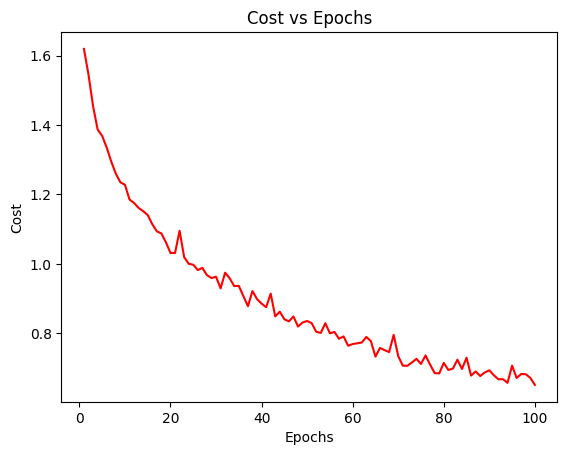

([2.7606997037578873,
  2.7453863440856576,
  2.448920538268875,
  2.2536964286968986,
  2.341716999042876,
  2.203572633460394,
  2.6881263963837796,
  2.4366060610049423,
  2.3967774340012706,
  2.4019995636681912,
  2.322357503076229,
  2.4053379215497217,
  2.444588374647183,
  2.240530270604478,
  2.4389481592153244,
  2.321183290184436,
  2.3266153301276664,
  2.210032182282137,
  2.316052957766723,
  2.0740937648856126,
  2.2894887365457235,
  2.031481738211692,
  2.2566636780632368,
  2.3438424291954316,
  2.263727653891208,
  2.2468956956322,
  2.354901512834343,
  2.157332097533258,
  2.224390331824618,
  2.187060160945367,
  2.2615877908897706,
  2.2951313388511574,
  2.235257181382103,
  2.304190262895436,
  2.2622230632854645,
  2.166990956957673,
  2.300653268197636,
  2.043410896862092,
  2.228336302739735,
  2.0425957024716777,
  2.236020503970902,
  2.253604865031727,
  2.1026373875711104,
  2.2367597061690043,
  2.248944359550889,
  2.176204111831118,
  2.099533860334

In [21]:
indxs = np.random.choice(1024,size=256,replace=False)
print(X.shape)
x_rndm = X[:,indxs]
print(x_rndm.shape)
l = [256,256,16,10]
fs = ['relu','relu','soft']
model15 = NeuralNetwork(l,fs,alpha=3e-2)
model15.train(x_rndm.T, Y_class, cost_func='soft',details=False, plot_costs=True)

Parameters initialized:  {'W1': (256, 1024), 'b1': (256, 1), 'W2': (16, 256), 'b2': (16, 1), 'W3': (10, 16), 'b3': (10, 1)}
Epoch: 001, Cost: 1.554679, accuracy: 44.9986
Epoch: 002, Cost: 1.464259, accuracy: 48.2222
Epoch: 003, Cost: 1.345785, accuracy: 53.1444
Epoch: 004, Cost: 1.300271, accuracy: 54.7556
Epoch: 005, Cost: 1.263328, accuracy: 55.6931
Epoch: 006, Cost: 1.203477, accuracy: 57.9625
Epoch: 007, Cost: 1.155889, accuracy: 60.1514
Epoch: 008, Cost: 1.145830, accuracy: 60.5292
Epoch: 009, Cost: 1.101390, accuracy: 61.8236
Epoch: 010, Cost: 1.138681, accuracy: 60.0847
Epoch: 011, Cost: 1.157458, accuracy: 60.3250
Epoch: 012, Cost: 1.027983, accuracy: 64.6986
Epoch: 013, Cost: 0.988702, accuracy: 65.7597
Epoch: 014, Cost: 0.972460, accuracy: 66.6056
Epoch: 015, Cost: 0.952343, accuracy: 67.3861
Epoch: 016, Cost: 0.971335, accuracy: 66.6194
Epoch: 017, Cost: 0.976711, accuracy: 66.6139
Epoch: 018, Cost: 0.862047, accuracy: 70.6333
Epoch: 019, Cost: 0.920480, accuracy: 68.3597
Ep

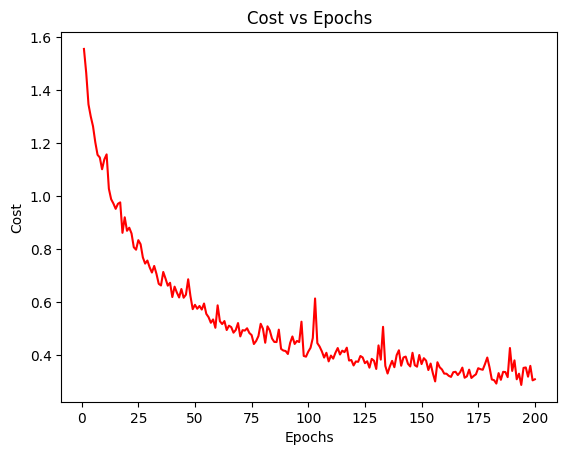

ValueError: shapes (256,1024) and (72000,1024) not aligned: 1024 (dim 1) != 72000 (dim 0)

In [22]:
model69 = NeuralNetwork([1024,256,16,10],['relu','relu','soft'], alpha = 3e-2,epochs=200,reg_param=1e-2)
J_history_batches, J_history_entire = model69.train(x_train.T, y_train_class, cost_func = 'soft',details=False,plot_costs=True)

In [23]:
print(f"Accuracy for training: {model69.get_accuracy(model69.predict(x_train.T),y_train_class)}")
print(f"Acc for testing: {model69.get_accuracy(model69.predict(x_test.T), y_test_class)}")
print("Tnis")

Accuracy for training: 89.2625
Acc for testing: 48.575
Tnis


Parameters initialized:  {'W1': (256, 1024), 'b1': (256, 1), 'W2': (8, 256), 'b2': (8, 1), 'W3': (10, 8), 'b3': (10, 1)}
Epoch: 001, Cost: 1.624221, accuracy: 41.7833
Epoch: 002, Cost: 1.526419, accuracy: 45.4444
Epoch: 003, Cost: 1.416593, accuracy: 50.3000
Epoch: 004, Cost: 1.387177, accuracy: 51.4139
Epoch: 005, Cost: 1.352394, accuracy: 52.7583
Epoch: 006, Cost: 1.318992, accuracy: 53.4708
Epoch: 007, Cost: 1.245217, accuracy: 56.3611
Epoch: 008, Cost: 1.240277, accuracy: 56.7514
Epoch: 009, Cost: 1.201675, accuracy: 58.1889
Epoch: 010, Cost: 1.217610, accuracy: 58.1042
Epoch: 011, Cost: 1.196690, accuracy: 58.1986
Epoch: 012, Cost: 1.168595, accuracy: 60.0042
Epoch: 013, Cost: 1.189573, accuracy: 59.3542
Epoch: 014, Cost: 1.133538, accuracy: 61.2097
Epoch: 015, Cost: 1.109264, accuracy: 62.1083
Epoch: 016, Cost: 1.105094, accuracy: 61.9056
Epoch: 017, Cost: 1.115238, accuracy: 61.2347
Epoch: 018, Cost: 1.069749, accuracy: 63.5389
Epoch: 019, Cost: 1.085551, accuracy: 62.4819
Epoch

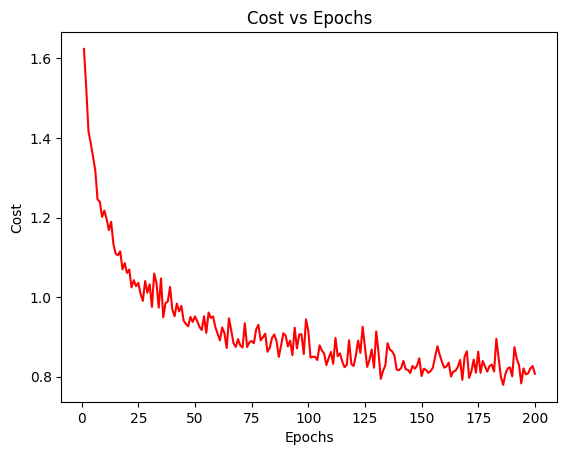

Accuracy for training: 2.8027777777777776
Acc for testing: 4.7625


In [27]:
model70 = NeuralNetwork([1024,256,8,10],['relu','relu','soft'], alpha = 3e-2,epochs=200,reg_param=1e-1)
J_history_batches, J_history_entire = model70.train(x_train.T, y_train_class, cost_func = 'soft',details=False,plot_costs=True)
print(f"Accuracy for training: {model70.get_accuracy(model70.predict(x_train.T),y_train_class)}")
print(f"Acc for testing: {model70.get_accuracy(model70.predict(x_test.T), y_test_class)}")

In [26]:
indxs = np.random.permutation(X.shape[0])
X = X[indxs]
Y_class = Y_class[indxs]
Y_bin = Y_bin[indxs]
x_train = X[:72000]
Y_class = Y_class -1
y_train_bin = Y_bin[:72000]
y_train_class = Y_class[:72000]
y_test_class = Y_class[72000:]
x_test = X[72000:]
y_test_bin = Y_bin[72000:]
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

In [28]:
print(f"Accuracy for training: {model70.get_accuracy(model70.predict(x_train.T),y_train_class)}")
print(f"Acc for testing: {model70.get_accuracy(model70.predict(x_test.T), y_test_class)}")

Accuracy for training: 2.8027777777777776
Acc for testing: 4.7625
